In [30]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re

dataset_id = "PXD020586" # Indicate Dataset Here
accessions =  ["PXD020586", "PXD017626"] # "MSV000086004", "PXD016573", "MSV000086809", "PXD027742",

# Make a preliminary for loop that generates the whole list of datasets using filepath and append psm["File_Name"].unique()

i = 0
for accession in accessions:
    
    filepath = accession + "/psm.TSV"
    
    psm_df = pd.read_csv(filepath, delimiter = "\t")
  
    psm_df = psm_df.loc[psm_df["PeptideProphet Probability"] > 0.99]
    
    # psm_df = psm_df.rename(columns={'sample-01': '126',  'sample-02': '127C', 'sample-03': '127N', 'sample-04': '128C', 'sample-05': '128N', 'sample-06': '129C',
    #                                 'sample-07': '129N', 'sample-08': '130C', 'sample-09': '130N', 'sample-10': '131C', 'sample-11': '131N', 'sample-12': '132C',
    #                                 'sample-13': '132N', 'sample-14': '133C', 'sample-15': '133N', 'sample-16': '134N', 'sample-17': '134C', 'sample-18': '135N'})
    
    psm_df["File_Name"] = psm_df["Spectrum File"].str.extract(r"^(?:.+\\)*interact-(.+)\.pep\.xml$")
    
    if (i == 0):
        datasets = psm_df["File_Name"].unique()
    else:
        datasets = np.concatenate((datasets, psm_df["File_Name"].unique()))
    
    i = i + 1
    
# Then make the medians_df
# Then use another for loop to fill it in

print(datasets)

['CellenONE_I3T_NEM_SC_Chip1_C1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H14_100pg_AGC300_1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H14_100pg_AGC300_2'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H210_100pg_AGC300_1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H210_100pg_AGC300_2'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H42_100pg_AGC300_1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H42_100pg_AGC300_2'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H434_100pg_AGC300_1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H434_100pg_AGC300_2'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H98_100pg_AGC300_1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H98_100pg_AGC300_2'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_No126_100pg_AGC300_1'
 '20200820_EXPL8_EVO1_ZY_SA_44min_TMT_No126_100pg_AGC300_2'
 '3celltype_singlecell_Boost1000_8May19_Oak_Jup-19-02-04'
 '3celltype_singlecell_Boost100_8May19_Oak_Jup-19-02-04'
 '3celltype_singlecell_noBoost_8May19_Oak_Jup-19-02-04'
 '20200514_MK_ES_E1200_precol_scMS_500ms_8227_P5_S1'
 '20200514_MK_ES_E1200_precol_scMS_500m

In [31]:
all_channels = ["126","127N","127C","128N","128C","129N","129C","130N","130C","131N","131C","132N","132C","133N","133C","134N","134C","135N"]
channels = ["127N","128N","128C","129N","129C","130N","130C","131N","131C","132N","132C","133N","133C","134N"]
medians_df = pd.DataFrame(index=datasets, columns=channels)
medians_df["Carrier Volume"] = ''

boost_volumes = set()

for accession in accessions:
    filepath = accession + "/psm.TSV"
    info_path = accession + "/sdrf.xlsx"
    
    psm_df = pd.read_csv(filepath, delimiter = "\t")
    sdrf_df = pd.read_excel(info_path)
    
    psm_df = psm_df.loc[psm_df["PeptideProphet Probability"] > 0.99]
    
    sdrf_df["label"] = sdrf_df["label"].astype(str)
    
    psm_df = psm_df.rename(columns={'sample-01': '126',  'sample-02': '127C', 'sample-03': '127N', 'sample-04': '128C', 'sample-05': '128N', 'sample-06': '129C',
                                    'sample-07': '129N', 'sample-08': '130C', 'sample-09': '130N', 'sample-10': '131C', 'sample-11': '131N', 'sample-12': '132C',
                                    'sample-13': '132N', 'sample-14': '133C', 'sample-15': '133N', 'sample-16': '134N', 'sample-17': '134C', 'sample-18': '135N'})
    
    psm_df["File_Name"] = psm_df["Spectrum File"].str.extract(r"^(?:.+\\)*interact-(.+)\.pep\.xml$")
    sdrf_df["File_Name"] = sdrf_df["file name"].str.extract(r"^(?:.+\\)*(.+)\.raw$")
    
    curr_datasets = psm_df["File_Name"].unique()
    
    curr_channels = []
    
    info_dict = {}
    
    for dataset in curr_datasets:
        info_dict[dataset] = sdrf_df.loc[sdrf_df["File_Name"] == dataset]
        
    first_info_df = info_dict[curr_datasets[0]]
    first_info_df.reset_index(drop=True, inplace=True)

    for channel in channels:
        if first_info_df.index[first_info_df["label"] == channel].tolist():
            row = first_info_df.index[first_info_df["label"] == channel].tolist()[0]
            channel_type = first_info_df["type"].iloc[row]

            if (channel_type == "single" or channel_type == "blank"): # May need to add condition that the channel is found in channels
                curr_channels.append(channel)

    psm_df = pd.melt(psm_df, id_vars=["File_Name"], value_vars=curr_channels)

    data_dict = {}
    for dataset in curr_datasets:
        data_dict[dataset] = psm_df.loc[psm_df["File_Name"] == dataset]
        
    
    for dataset in curr_datasets:
        info_df = info_dict[dataset]

        info_df.reset_index(drop=True, inplace=True)

        all_channels = info_df["label"]
        boost_volume = 0

        for channel in all_channels:
            row = info_df.index[info_df["label"] == channel].tolist()[0]
            channel_type = info_df["type"].iloc[row]
            if (channel_type == "boost"):
                boost_volume += info_df["cell_equivalents"].iloc[row]

        boost_volumes.add(boost_volume)


        medians_df.at[dataset, "Carrier Volume"] = boost_volume

    
    # print(curr_channels)
    # channels = ["127N","128N","128C","129N","129C","130N","130C"] # ,"131N","131C","132N","132C","133N","133C","134N"] #Excluding 126 and 127C because reasons

    
    
    for dataset in curr_datasets:
        curr_df =  data_dict[dataset]
        for channel in curr_channels:
            chan_df = curr_df.loc[curr_df["variable"] == channel]
            medians_df.at[dataset, channel] = chan_df['value'].median()

medians_df['Median'] = medians_df[channels].median(axis=1)

medians_df["Carrier Volume"] = pd.to_numeric(medians_df["Carrier Volume"], errors='coerce')
medians_df.sort_values(by=["Carrier Volume"], ascending=True)

medians_df["Carrier Volume"] = medians_df["Carrier Volume"].astype(int)
# medians_df["Carrier Volume"] = medians_df["Carrier Volume"].astype(str) + "x"


print(boost_volumes)

# psm_df
# sdrf_df
# first_info_df
medians_df
    
    
    
# psm_df["value"] = psm_df["value"].apply(np.log10)
# psm_df["value"] = np.log10(psm_df["value"].replace(0, np.nan))

{0.0, 98.0, 100, 1000.0, 200.0, 42.0, 14.0, 434.0, 210.0}


,127N,128N,128C,129N,129C,130N,130C,131N,131C,132N,132C,133N,133C,134N,Carrier Volume,Median
CellenONE_I3T_NEM_SC_Chip1_C1,7563.0835,0.0,406.273,0.0,0.0,287.4225,853.0741,616.8061,1200.5364,899.806,759.8973,918.5305,3444.9421,819.7184,100,789.807850
20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H14_100pg_AGC300_1,18881.9648,21571.6074,21546.6348,22032.1504,21720.3711,19662.6133,21321.5098,19278.1758,19585.4785,19105.3867,18365.2617,21667.4199,16267.752,20029.834,14,19846.223650
20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H14_100pg_AGC300_2,18754.2246,21472.7588,21153.64845,21750.86915,21220.82225,19760.9502,20741.833,19152.74805,19658.75095,19024.5625,18405.48145,21549.17285,16025.0171,19783.11035,14,19772.030275
20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H210_100pg_AGC300_1,17819.01565,13464.6294,16351.24465,13132.41015,13021.77685,11961.5972,12519.26415,11889.97995,12081.2915,11502.251,11708.0835,12799.05905,10005.24025,12313.9287,210,12416.596425
20200820_EXPL8_EVO1_ZY_SA_44min_TMT_H210_100pg_AGC300_2,18971.4502,14238.2671,17853.96585,13744.16945,13682.88965,12541.19385,13461.61475,12552.8589,13053.0254,12016.51615,11893.76415,13785.38915,10597.5249,12911.5376,210,13257.320075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200519_MK_ES_E1200_precol_scMS_300ms_8227_P6_S20,1129.57955,1306.336,1128.3147,947.2416,1201.2938,1233.1398,1180.90285,754.2004,1141.71775,811.8531,1070.50155,959.37165,960.79085,1055.4102,200,1099.408125
20200519_MK_ES_E1200_precol_scMS_300ms_8227_P6_S21,1166.2872,1382.3016,950.2609,1001.9832,1061.1556,1145.9133,1011.6239,991.6218,1090.3831,882.3556,854.4887,766.7684,843.3572,824.2397,200,996.802500
20200519_MK_ES_E1200_precol_scMS_300ms_8227_P6_S22,1108.4351,1747.8993,2223.698,1271.9579,3296.7869,1621.5188,1791.1978,1123.8671,1060.1265,851.0353,1010.5619,1022.3672,954.4255,1068.1758,200,1116.151100
20200519_MK_ES_E1200_precol_scMS_300ms_8227_P6_S23,1076.41525,1372.39165,1094.1027,910.2625,984.3011,1147.02945,1081.6438,978.6324,1119.926,937.40985,856.77025,1226.1933,979.482,940.7375,200,1030.358175


In [33]:
variance_df = pd.DataFrame(index=datasets, columns=channels)
variance_df = variance_df.assign(Boost=medians_df["Carrier Volume"])

for dataset in datasets:
    for channel in channels:
        variance_df.at[dataset, channel] = medians_df.at[dataset, channel] / medians_df.at[dataset, "Median"]

# sigmas = variance_df[channels].std()
sigma = np.nanstd(variance_df[channels])
mean = np.nanmean(variance_df[channels])
# print(sigmas)
print(sigma)
print(mean)

for dataset in datasets:
    for channel in channels:
        # curr_col = variance_df[channel]
        # variance_df = variance_df[(curr_col <= mean+(5*sigma))]
        
        if (variance_df.at[dataset, channel] > mean+(5*sigma)): 
            variance_df.at[dataset, channel] = np.nan
            
        
variance_df
variance_df.to_csv("variance.csv")



1.1763862719579776
1.1054090030676853


In [28]:
boost_volumes = set()

variance_df["Carrier Volume"] = ''

# variance_df["Injection Time"] = ''
for accession in accessions:
for dataset in datasets:
    info_df = info_dict[dataset]
    
    info_df.reset_index(drop=True, inplace=True)
    
    all_channels = info_df["label"]
    boost_volume = 0
    
    for channel in all_channels:
        row = info_df.index[info_df["label"] == channel].tolist()[0]
        channel_type = info_df["type"].iloc[row]
        if (channel_type == "boost"):
            boost_volume += info_df["cell_equivalents"].iloc[row]
    
    boost_volumes.add(boost_volume)
    
#     if "300ms" in dataset:
#         variance_df.at[dataset, "Injection Time"] = "300ms"
#         
#     elif "500ms" in dataset:
#         variance_df.at[dataset, "Injection Time"] = "500ms"
    
    variance_df.at[dataset, "Carrier Volume"] = boost_volume
    
variance_df["Carrier Volume"] = pd.to_numeric(variance_df["Carrier Volume"], errors='coerce')
variance_df.sort_values(by=["Carrier Volume"], ascending=True)

variance_df["Carrier Volume"] = variance_df["Carrier Volume"].astype(int)
# variance_df["Carrier Volume"] = variance_df["Carrier Volume"].astype(str) + "x"


print(boost_volumes)

variance_df


KeyError: 'CellenONE_I3T_NEM_SC_Chip1_C1'

In [4]:
counts_df = pd.DataFrame(index=["Above","Below", "Average", "St Dev"], columns=channels)

for channel in channels:
    column = variance_df[channel]
    counts_df.at["Above", channel] = column[column > 1.00].count()
    counts_df.at["Below", channel] = column[column < 1.00].count()
    counts_df.at["Average", channel] = column.mean()
    counts_df.at["St Dev", channel] = column.std()
    
counts_df

,127N,128N,128C,129N,129C,130N,130C,131N,131C,132N,132C,133N,133C,134N
Above,28,42,28,20,32,33,16,19,37,9,20,19,12,18
Below,20,4,20,28,16,15,32,29,11,39,28,28,36,30
Average,1.07548,1.26675,1.05594,1.003432,1.113858,1.06737,0.962011,0.986602,1.108945,0.92775,1.009587,1.004344,0.995471,0.938962
St Dev,0.162805,0.189737,0.203284,0.419075,0.356395,0.176975,0.180635,0.215731,0.268211,0.17184,0.390496,0.311996,0.367005,0.127813


In [22]:
# ANOVA table using bioinfokit v1.0.3 or later (it uses wrapper script for anova_lm)
from bioinfokit.analys import stat
variance_df.reset_index(drop=True, inplace=True)

anova_df = pd.melt(variance_df.reset_index(), id_vars=['index'], value_vars=channels, ignore_index=False)

anova_df.columns = ['index', 'treatments', 'value']

res = stat()

anova_df



# res.anova_stat(df=anova_df, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary


# output (ANOVA F and p value)
#                  df   sum_sq   mean_sq         F    PR(>F)
# C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
# Residual       16.0   918.00    57.375       NaN       NaN

# note: if the data is balanced (equal sample size for each group), Type 1, 2, and 3 sums of squares
# (typ parameter) will produce similar results.

,index,treatments,value
0,0,127N,0.992599
1,1,127N,1.292226
2,2,127N,1.257541
3,3,127N,1.248282
4,4,127N,1.081915
...,...,...,...
43,43,134N,0.95998
44,44,134N,0.826884
45,45,134N,0.957017
46,46,134N,0.91302


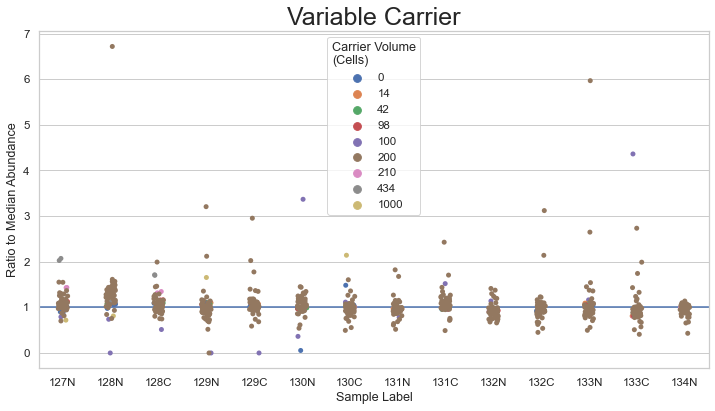

In [39]:
to_graph_df = pd.melt(variance_df, id_vars=["Boost"], value_vars=channels, ignore_index=False) # ,"131N","131C","132N","132C","133N","133C","134N"]
to_graph_df["Dataset"] = to_graph_df.index
to_graph_df

plt.figure(figsize=(12, 6.2025)) # Original: (16, 8.27)

sns.set(font_scale=1.05)
sns.set_style("whitegrid")

title = "Variable Carrier"    
boxplot = sns.stripplot(data=to_graph_df, x="variable", y="value", jitter=True, hue="Boost", order=channels)
    
plt.legend(title="Carrier Volume\n(Cells)") # , alignment="center") # Need to Update matplotlib


boxplot.set_title(title, fontsize=25)

plt.axhline(y=1)

boxplot.set(xlabel="Sample Label", ylabel="Ratio to Median Abundance") # Change y label

plt.savefig("overall_median_figure.png", dpi=400)
plt.show()

In [16]:
test_df = pd.read_csv("https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt", sep="\t")
# reshape the d dataframe suitable for statsmodels package
test_df = test_df.rename(columns={"A": "126"})
test_df.at[3, "B"] = np.nan
df_melt = pd.melt(test_df.reset_index(), id_vars=['index'], value_vars=['126', 'B', 'C', 'D'])
# replace column names
df_melt.columns = ['index', 'treatments', 'value']

df_melt

# res.anova_stat(df=df_melt, res_var='value', anova_model='value ~ C(treatments)')
# res.anova_summary

# IDEAS:
# -Get the ANOVA working
# -Get this working for multiple publications at once
# -Use open dots for blank channels, filled for samples
# 

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),3.0,2939.355263,979.785088,19.167625,0.000022
Residual,15.0,766.750000,51.116667,NaN,NaN
